# Inferring the Vehicle Type with Neural Networks

Ruggero Fabbiano – 25 February 2021

## Introduction

In a previous exploratory notebook (*Analysis of Urban-Traffic Simulated Data – part II*) we noticed an issue with pedestrians objects in SUMo MoST: a lot of the objects classified as pedestrians actually show a behaviour that is not really belonging to this class. The idea behind this notebook is to use deep learning to correctly classify the type of such vehicles.

#### Why Deep Learning?

Our data set can be thought as composed by multi-variate time-series (after proper manipulation) of vehicle trips around the Monaco area. As we know, the `sktime` package (a kind of "SKLearn version for time-series") has been conceived to treatspecifically this kind of data, and is supposed to provide better results than deep learning for multi-variate classification. So why deep learning?

The answer is that this article is meant to provide a "comparison" (or better, a parallel work) with our other vehicle classification work that already uses SKTime (*Vehicle Type Prediction Using Simulated Trajectory Data*, by Pedro Venturott), to help us understand if there is a better way to approach such problem, and if so, what it is.

## The Data

For the sake of comprehension we will use here the same data used in the exploratory notebook cited here above. Moreover, we suppose to have already carried out all the "data cleaning" that is done there.
    
We can then proceed to import the data previously saved, after installing and importing the needed packages.

## Install Needed Packages

In [1]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install tensorflow

## Import Packages and Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

plt.style.use('bmh')

In [3]:
data = pd.read_pickle("MoST_0600_0830_processed.pkl")
data.head()

,t,angle,ID,lane_edge,position,slope,speed,type,x,y,z,time
2,21600.0,50.48,pedestrian_2-1_3985_tr,153330#1_1,2.2,-1.57,0.0,moped,4811.50,2704.21,143.81,06:00:00
3,21600.0,50.48,pedestrian_2-1_3985,153330#1,2.20,-1.55,0.0,pedestrian,4811.50,2704.21,143.81,06:00:00
4,21600.0,307.42,pedestrian_2-1_5063_tr,152413#3_1,2.3,-6.20,0.0,motorcycle,2006.06,3313.49,400.40,06:00:00
5,21600.0,307.42,pedestrian_2-1_5063,152413#3,2.30,-6.20,0.0,pedestrian,2006.06,3313.49,400.40,06:00:00
6,21600.0,121.94,pedestrian_2-1_5887_tr,-152557#1_1,2.3,-0.04,0.0,motorcycle,6482.50,3763.28,57.60,06:00:00


## Framing the Problem

As we already said in the introduction, we want to classify vehicles; in particular, we want to re-classify objects that the MoST scenario wrongly labels as pedestrianss.

Dealing with deep learning and multi-variate time-series, we have two main approaches to choose from:
* Perform a feature-engineering task to extract static features from the time-series (*e.g.*, average speed, time spend queueing, max. speed, max. acceleration and so on), and then fed them to any standard classification algorithm.
* Use our dataframe as-is (that of course, is never really *as-is*...) and using directly time-series as our to-be-classified data; in this second case we can
    * split the time-series into several fixed-length windows and feed them directly to a convolutional neural network, that basically do the feature extraction on its own;
    * use a neural network that naturally consumes time-series data.

To fully exploit the *time-series* data property we will use this second approach, even if it could prove to be more complex / resource-intensive. In particular, we will build a recurrent neural network, that can be directly fed with time-series data.

## Selecting the Good Features

The first step is obviously to select the good features for our classification problem. Let's recapitulate them:

In [4]:
data.columns

Index(['t', 'angle', 'ID', 'lane_edge', 'position', 'slope', 'speed', 'type',
       'x', 'y', 'z', 'time'],
      dtype='object')

* We will surely keep `t` and `ID`, to have the time indication and be able to distinguish the different time-series (<font color="" aqua>is time really necessary though?</font>); we won't need the redundant feature `time`.
* `angle`, `position`, `slope`, `x`, `y`, `z` are "tolopogical" variables related to the lane the vehicle is in, so probably not very interesting; at the same time, their being numeric can prove useful as lane can be too complicated to use.
* As said before, `lane_edge` associated with the time information can help us dissociate the intrinsic vehicle behaviour from the traffic conditions; at the same time, encoding all the possible lanes can become challenging.
* `speed` and `type` are without any doubt the most important features: the first one is the one that probably better describes a vehicle behaviour, while the latter will be our classification goal.

In conclusion, keeping the `x`/`y` position instead of the lane information will probably prove wiser. Let's proceed:

In [5]:
data = data[['t', 'ID', 'x', 'y', 'speed', 'type']]
data.head()

,t,ID,x,y,speed,type
2,21600.0,pedestrian_2-1_3985_tr,4811.50,2704.21,0.0,moped
3,21600.0,pedestrian_2-1_3985,4811.50,2704.21,0.0,pedestrian
4,21600.0,pedestrian_2-1_5063_tr,2006.06,3313.49,0.0,motorcycle
5,21600.0,pedestrian_2-1_5063,2006.06,3313.49,0.0,pedestrian
6,21600.0,pedestrian_2-1_5887_tr,6482.50,3763.28,0.0,motorcycle


We can also think about extract new features: one good candidate seems to be approximate acceleration. Let's do it but... don't run it for the moment ;)
It can take quite a lot of time, so better postpone when our data-set will be reduced to what we really need...

In [6]:
def set_acc(data_set, ID_feat='ID', speed_feat='speed'):
    for ID in data_set[ID_feat].unique():
        ID_data = data_set[data_set[ID_feat]==ID]
        ID_acc = ID_data[speed_feat].diff()/5/3.6 # T = 5s [m/s²]
        data_set.loc[ID_acc.index, 'acceleration'] = ID_acc
    return data_set.dropna(axis=0)

Let us also check that our feature values are well-formatted numeric (we already checked it for speed in the previous notebook):

In [7]:
def process_values(x):
    try: return float(x)
    except ValueError: return np.NaN # we might have abnormal values

data[['x', 'y']] = data[['x', 'y']].applymap(process_values)

Were there anomalous values?

In [8]:
anomalies = data[(data['x'].isna()) | (data['y'].isna())]
anomalies

,t,ID,x,y,speed,type
1024317,23575.0,pedestrian_1-2_2838_tr,NaN,NaN,9.936,motorcycle
1024318,23575.0,pedestrian_1-2_2838,NaN,NaN,9.936,pedestrian
2923468,25410.0,pedestrian_1-2_4375_tr,NaN,NaN,19.584,motorcycle
2923469,25410.0,pedestrian_1-2_4375,NaN,NaN,19.584,pedestrian


Only 4, let's drop them. We'll drop the whole time-series to avoid incoherences due to holes in the data series; also, since they are very few, it is not worth to fine-work on the relative time-series to impute them.

In [9]:
data = data[~data['ID'].isin(anomalies['ID'].unique())]

## Selecting Time-Series

Before splitting our data set, we have to set a uniform length for our time-series: let's choose 20 minutes as the default length.

Thus, we have to filter out vehicles with a shorter travel time:

In [10]:
TS_lengths = data.groupby('ID')['t'].count()
L = 20*60/5 # number of desired steps
usable_obj = TS_lengths[TS_lengths>=L].index

data = data[data['ID'].isin(usable_obj)]

## Splitting the Data Set

The next step is divide our data set into training and testing sets.

First we have to take out the pedestrians we want to re-classify, as this will be our "production inference" data set; then we have to get train and test sets from the remaining data.

In [ ]:
To do so, we have to remember that we want to classify pedestrians. Nonetheless, we cannot just move all of them into testing set, because the model should learn also what a pedestrian time-series looks like!
We need to find a simple method to get what could be "true" pedestrians.

Let's naively start with speed.

First, how many possible pedestrians we have?

In [27]:
all_ped = data[data['type']=='pedestrian']['ID'].unique()
all_obj = data['ID'].unique()

print(F"{len(all_ped)} pedestrians out of {len(all_obj)} objects")

4967 pedestrians out of 12489 objects


A bit more than a third, knowing that before filtering out time-series it was almost half (from previous notebook): we have dropped a lot of pedestrians in proportions!

[SUMo vehicle type parameter defaults](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html) tell us v=5.4 km/h. With some variation (std=0,1), more than 99 % of pedestrians should have v_max<=5,7. let's choose a speed of 6 km/h as limit.

In [28]:
ped_v_max = data[data['type']=='pedestrian'].groupby('ID')['speed'].max()

In [32]:
real_ped = ped_v_max[ped_v_max<6]

len(real_ped)

46

46! Less than 1 % of the total "possible pedestrians" have a max. speed lower than the maximum declared!

Let's do a kind of "manual sanity check" on these 460 on acceleration. [SUMo vehicle type parameter defaults](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html) tell us a_max = 1.5, a_min = -2, (m/s2). With some variation (std=0,1), more than 99 % of pedestrians should have a_max<1,8 and a_min>-2,3. Let's choose a -2,5<a<2.

In [33]:
ped_speeds = data[data['type']=='pedestrian'][['ID', 'speed']]
real_ped = pd.DataFrame(real_ped)

In [34]:
def get_acc_peaks(ID):
    acc = ped_speeds[ped_speeds['ID']==ID]['speed'].diff()[1:]/5/3.6 # m/s^2
    try:
        return min(acc), max(acc)
    except ValueError:
        return 0, 0

def set_acc_peaks(DF):
    ind, acc_min, acc_max = [], [], []
    for obj_ID, _ in DF.iterrows():
        m, M = get_acc_peaks(obj_ID)
        ind.append(obj_ID)
        acc_min.append(m)
        acc_max.append(M)
    return pd.DataFrame({"min.": acc_min, "max.": acc_max}, index=DF.index)

In [35]:
real_ped[["a min.", "a max."]] = set_acc_peaks(real_ped)

In [36]:
assert real_ped[real_ped['a min.']<-2.5].empty
assert real_ped[real_ped['a max.']>2].empty

OK, those will then be our "real" pedestrians. The other will be the objects to be classified.

In [37]:
to_classify = data[data['ID'].isin(ped_v_max[ped_v_max>6].index)]
train_test_data = data[~data['ID'].isin(to_classify['ID'])]

How many vehicles do we have to classify, and with how many ojects?

In [38]:
len(to_classify['ID'].unique()), len(train_test_data['ID'].unique())

(4921, 7568)

Almost good. But, before proceeding, let's look how our data set is (un)balanced... 

In [39]:
object_type = train_test_data.groupby('ID')['type'].min()
n_obj = len(object_type)
for obj_type in object_type.unique():
    n_type = len(object_type[object_type==obj_type])
    print(obj_type + F": {n_type} ({n_type/n_obj:.2%})")

bus: 108 (1.43%)
lorry: 28 (0.37%)
delivery: 108 (1.43%)
pedestrian: 46 (0.61%)
bicycle: 9 (0.12%)
motorcycle: 1327 (17.53%)
moped: 579 (7.65%)
car: 5309 (70.15%)
hire: 5 (0.07%)
special: 49 (0.65%)


We could drop pedestrians for sure, since we know from our previous "classification" that what we try to classify are not pedestrians. Anyway, we might end up reclassifying some of them as real pedestrians.
Let's drop for sure hire and bicycles, they are too few to be used.
Then we can take all the other instances for type below 150 objects, and sample 150 for the others. It still will be a bit unbalanced, but let's see how the model behaves.

In [40]:
# CHECK-POINT 1
data.to_pickle("data_1.pkl")
train_test_data.to_pickle("train_test_data_1.pkl")
to_classify.to_pickle("to_classify_1.pkl")

In [41]:
train_test_data = train_test_data[~train_test_data['type'].isin(['bicycle', 'hire'])]

In [44]:
to_sample = ['moped', 'motorcycle', 'car']
IDs = []
for v_type in to_sample:
    IDs.extend(object_type[object_type==v_type].sample(150, random_state=1).index)

In [45]:
train_test_data = train_test_data[~((train_test_data['type'].isin(to_sample)) &
                                    (~train_test_data['ID'].isin(IDs)))]

Now we have to split our training data set. We do this on each tipe so as to have the same balance, and we keep the base split 1:4. But before, this is finally the moment to create the acceleration feature. Do you remember? Our data set is as small as possible, so better now... launch this and go grab a coffee!

In [67]:
%time

train_test_data = set_acc(train_test_data)
to_classify = set_acc(to_classify)

C:\Users\rugge\Anaconda\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\rugge\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Let's check:

In [104]:
col = train_test_data.columns[:-2].to_list()
col.extend(['acceleration', 'type'])

train_test_data = train_test_data[col]
to_classify = to_classify[col]

train_test_data

,t,ID,x,y,speed,acceleration,type
120,21615.0,pedestrian_2-1_6106_tr,4072.08,1027.45,22.608,0.804,moped
207,21620.0,pedestrian_2-1_6106_tr,4049.45,993.85,35.892,0.738,moped
316,21625.0,pedestrian_2-1_6106_tr,4041.39,940.50,50.292,0.800,moped
449,21630.0,pedestrian_2-1_6106_tr,4102.44,968.04,56.736,0.358,moped
521,21635.0,pedestrian_1-1-veh_894_tr,5739.38,3076.56,16.128,0.896,moped
...,...,...,...,...,...,...,...
12077880,30595.0,pedestrian_1-1-pt_2375,5404.45,2340.98,0.000,0.000,pedestrian
12077938,30595.0,pedestrian_1-1-pt_7348,4749.34,1634.91,0.000,0.000,pedestrian
12077940,30595.0,pedestrian_1-1-pt_3726,4724.84,1831.69,0.000,0.000,pedestrian
12077941,30595.0,pedestrian_1-1-pt_4160,4724.90,1832.49,0.000,0.000,pedestrian


OK, back to our split!

In [108]:
test_IDs = []
for v_type in train_test_data['type'].unique():
    single_type = train_test_data[train_test_data['type']==v_type]['ID'].unique()
    test_IDs.extend(np.random.choice(single_type, int(len(A)*0.25)))

train_data = train_test_data[~train_test_data['ID'].isin(test_IDs)]
test_data = train_test_data[train_test_data['ID'].isin(test_IDs)]

In [109]:
len(train_data['ID'].unique()), len(test_data['ID'].unique())

(603, 186)

In [110]:
# CHECK-POINT 2
train_test_data.to_pickle("train_test_data_2.pkl")
to_classify.to_pickle("to_classify_2.pkl")
train_data.to_pickle("train_data_2.pkl")
test_data.to_pickle("test_data_2.pkl")

## Creating Vectors

We have a lot of different features, better scale them...

In [113]:
features = ['speed', 'x', 'y']

scaler = RobustScaler()
scaler = scaler.fit(train_data[features])
train_data.loc[:, features] = scaler.transform(train_data[features].to_numpy())
test_data.loc[:, features] = scaler.transform(test_data[features].to_numpy())
to_classify.loc[:, features] = scaler.transform(to_classify[features].to_numpy())

In [114]:
# CHECK-POINT 3
train_data.to_pickle("train_data_3.pkl")
test_data.to_pickle("test_data_3.pkl")
to_classify.to_pickle("to_classify_3.pkl")

Now we have to create our train and test data sets. To exploit time properties of time-series we create repetitions shifted of each time-series object.

In [116]:
def create_learning_vectors(dataset, X_features=features, l_max=int(L), time_steps=80, step=20, y_feature='type'):
    X, y = [], []
    for obj in dataset['ID'].unique():
        obj_data = dataset[dataset['ID']==obj].reset_index(drop=True)
        for i in range(0, l_max-time_steps, step):
            TS_slice = obj_data.iloc[i:i+time_steps][X_features].values
            X.append(TS_slice)
            y.append(obj_data[y_feature].unique())
    return np.array(X), np.array(y)

Another time to grab a coffee...

In [118]:
%%time

X_train, y_train = create_learning_vectors(train_data)
X_test, y_test = create_learning_vectors(test_data)
# X_to_classify, _ = create_learning_vectors(to_classify) # let's postpone it, too heavy

Wall time: 24.3 s


One last thing: we have to encode the output categorical variables!

In [120]:
encoder = OneHotEncoder(sparse=False)
encoder = encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [121]:
# CHECK-POINT 4
np.save("X_train_4.npy", X_train)
np.save("y_train_4.npy", y_train)
np.save("X_test_4.npy", X_test)
np.save("y_test_4.npy", y_test)
# np.save("X_to_classify_4.npy", X_to_classify)

In [79]:
# LOAD
train_data = pd.read_pickle("train.pkl")
test_data = pd.read_pickle("test.pkl")
np.load("X_train.npy")
np.load("y_train.npy")

## Building the Classification Model

OK, time to build our model and see what it does!
As we said we use long short-term memory (LSTM) recurrent neural network (RNN) architecture.
<font color="aqua">Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).</font>

In [123]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [124]:
LSTM_RNN = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1,shuffle=True)

Train on 4341 samples, validate on 483 samples
Epoch 1/20
4341/4341 [==============================] - 22s 5ms/sample - loss: 1.5664 - acc: 0.3642 - val_loss: 1.5134 - val_acc: 0.4079
Epoch 2/20
4341/4341 [==============================] - 24s 6ms/sample - loss: 1.2666 - acc: 0.4729 - val_loss: 1.3827 - val_acc: 0.4555
Epoch 3/20
4341/4341 [==============================] - 29s 7ms/sample - loss: 1.1954 - acc: 0.5050 - val_loss: 1.3980 - val_acc: 0.4534
Epoch 4/20
4341/4341 [==============================] - 30s 7ms/sample - loss: 1.1088 - acc: 0.5483 - val_loss: 1.3632 - val_acc: 0.4596
Epoch 5/20
4341/4341 [==============================] - 33s 8ms/sample - loss: 1.0463 - acc: 0.5711 - val_loss: 1.3308 - val_acc: 0.5010
Epoch 6/20
4341/4341 [==============================] - 28s 7ms/sample - loss: 0.9524 - acc: 0.6188 - val_loss: 1.2390 - val_acc: 0.5259
Epoch 7/20
4341/4341 [==============================] - 26s 6ms/sample - loss: 0.9288 - acc: 0.6181 - val_loss: 1.2189 - val_acc: 0

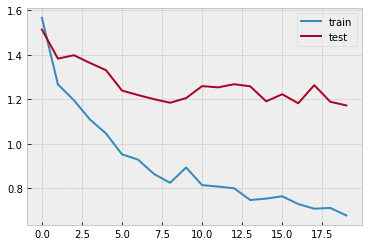

In [128]:
plt.plot(LSTM_RNN.history['loss'], label='train')
plt.plot(LSTM_RNN.history['val_loss'], label='test')
plt.legend();

In [129]:
model.evaluate(X_test, y_test)

1488/1488 [==============================] - 3s 2ms/sample - loss: 1.1002 - acc: 0.5806 2s - los - ETA: 1s - loss: 0.8583 - acc: 0.63 - ETA: 1s - loss: 0.88


[1.1001510139797583, 0.58064514]

In [130]:
y_pred = model.predict(X_test)

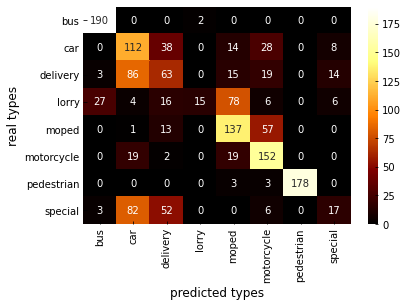

In [163]:
y_true = encoder.inverse_transform(y_test)
y_model = encoder.inverse_transform(y_pred)
CM = confusion_matrix(y_true, y_model)

_, ax = plt.subplots() 
ax = sns.heatmap(CM, annot=True, fmt="d", cmap='afmhot')
plt.ylabel('real types')
plt.xlabel('predicted types')
ax.set_xticklabels(encoder.categories_[0], rotation='vertical')
ax.set_yticklabels(encoder.categories_[0], rotation='horizontal');

## Open Questions

5. With/without time as feature
2. Use x/y or not?
3. Really need for acceleration if RNN extracts features by itself?
4. Do we really need to uniform time-series with this approach?
5. Unbalanced data-set...
6. Really need for sliding windows (and the other windows :))?